<a href="https://colab.research.google.com/github/k-vinamr/rera_construction_pred/blob/main/8_floor_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
# Load your dataset
data = pd.read_csv('augmented_8_floor.csv')

In [66]:
data

,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,total_days,Cleaning & survey,...,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work,duration_since_commencement,remaining_duration,progress_ratio,current_stage,area_bin
0,SHREE SWAMI SAMARTH PROMOTERS AND DEVELOPERS,Residential/Group Housing,02-09-2022,31-12-2023,685.000000,141.300000,8,MAHARASHTRA,485,2.313931,...,41.650763,41.650763,25.453244,41.650763,13.883588,423,61,0.872165,running,"(500, 1000]"
1,Orion Developers,Residential/Group Housing,20-06-2022,31-12-2025,419.720000,148.800000,8,MAHARASHTRA,1290,6.154580,...,110.782443,110.782443,67.700382,110.782443,36.927481,497,792,0.385271,running,"(0, 500]"
2,GLOBAL CONSTRUCTIONS,Residential/Group Housing,09-09-2021,30-03-2022,326.950000,152.300000,8,MAHARASHTRA,202,0.963740,...,17.347328,17.347328,10.601145,17.347328,5.782443,781,-580,3.866337,completed,"(0, 500]"
3,VERSATILEREALTORSPRIVATELIMITED,Residential/Group Housing,18-05-2020,30-09-2020,798.210000,152.750000,8,MAHARASHTRA,135,0.644084,...,11.593511,11.593511,7.084924,11.593511,3.864504,1260,-1126,9.333333,completed,"(500, 1000]"
4,ARFA REALTIES,Residential/Group Housing,24-01-2023,31-07-2024,851.970000,154.700000,8,MAHARASHTRA,554,2.643130,...,47.576336,47.576336,29.074427,47.576336,15.858779,279,274,0.503610,running,"(500, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Shrinath Developers,Residential/Group Housing,07-09-2021,26-05-2022,767.359392,1406.314254,8,MAHARASHTRA,263,1.254771,...,22.585878,22.585878,13.802481,22.585878,7.528626,781,-519,2.969582,completed,"(500, 1000]"
19996,Dipti Home Makers Pvt Ltd,Residential/Group Housing,15-09-2021,06-08-2022,17438.471230,4812.919934,8,MAHARASHTRA,325,1.550573,...,27.910305,27.910305,17.056298,27.910305,9.303435,781,-457,2.403077,completed,"(17000, 17500]"
19997,MUNISH GROUP OF COMPANY,Residential/Group Housing,14-06-2022,27-12-2027,4548.256675,2566.508795,8,MAHARASHTRA,2025,9.661260,...,173.902672,173.902672,106.273855,173.902672,57.967557,502,1522,0.247901,running,"(4500, 5000]"
19998,SAI SHRUSHTI ENTERPRISES,Residential/Group Housing,02-09-2021,05-01-2022,1818.804599,1033.712488,8,MAHARASHTRA,112,0.534351,...,9.618321,9.618321,5.877863,9.618321,3.206107,781,-670,6.973214,completed,"(1500, 2000]"


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 55 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   organisation_name                                                          20000 non-null  object 
 1   project_category                                                           20000 non-null  object 
 2   actual_commencement_date                                                   20000 non-null  object 
 3   estimated_finish_date                                                      20000 non-null  object 
 4   total_built_up_area_saleable_area                                          20000 non-null  float64
 5   total_area_of_project                                                      20000 non-null  float64
 6   floor                                                 

In [68]:
# Converting date columns to datetime objects
data['actual_commencement_date'] = pd.to_datetime(data['actual_commencement_date'], errors='coerce')
data['estimated_finish_date'] = pd.to_datetime(data['estimated_finish_date'], errors='coerce')

<ipython-input-68-1b85272236a7>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['actual_commencement_date'] = pd.to_datetime(data['actual_commencement_date'], errors='coerce')
<ipython-input-68-1b85272236a7>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['estimated_finish_date'] = pd.to_datetime(data['estimated_finish_date'], errors='coerce')


In [69]:
current_date = datetime.now()

In [70]:
data['duration_since_commencement'] = (current_date - data['actual_commencement_date']).dt.days
data['remaining_duration'] = (data['estimated_finish_date'] - current_date).dt.days
data['progress_ratio'] = data['duration_since_commencement'] / data['total_days']

In [71]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
data['current_stage'] = data.apply(determine_status, axis=1)

In [72]:
data.columns

Index(['organisation_name', 'project_category', 'actual_commencement_date',
       'estimated_finish_date', 'total_built_up_area_saleable_area',
       'total_area_of_project', 'floor', 'project_state', 'total_days',
       'Cleaning & survey', 'Excavation,leveling & P.C.C  for Basement  B1 ',
       ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ',
       'Slab of B (bottom) ', ' Ground Floor slab casting ',
       ' 1st floor Columns casting', ' 1st Floor slab casting',
       '2nd floor Columns casting ', '2nd Floor slab casting',
       ' Brick work at Basement to Ground Floor ',
       'Electrical concealed, PVC Fitting, plastering at Basement',
       '3rd floor Columns casting ', '3rd Floor slab casting',
       ' Brick work at 1st Floor ',
       'Electrical concealed, PVC Fitting, plastering at ground floor',
       '4th floor Columns casting ', '4th Floor slab casting',
       ' Brick work at 2nd Floor ',
       'Electrical concealed, PVC Fitting, p

In [73]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
data['current_stage'] = data['current_stage'].astype(str) # Converting to string to handle any NaN values left
data['current_stage_encoded'] = label_encoder.fit_transform(data['current_stage'])

In [74]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
data['project_state'] = data['project_state'].astype(str) # Converting to string to handle any NaN values left
data['project_state_encoded'] = label_encoder.fit_transform(data['project_state'])

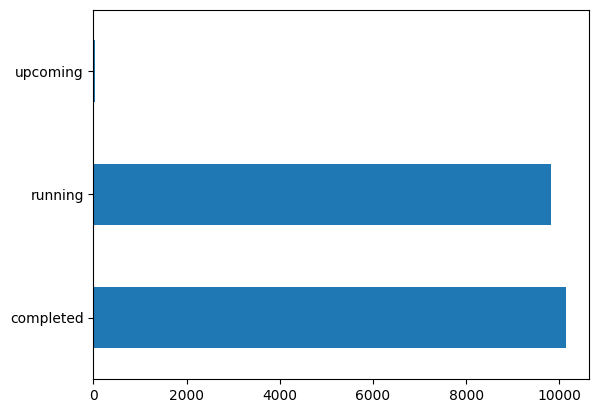

In [75]:
(data['current_stage'].value_counts()).plot(kind='barh'); plt.show()

In [76]:
data['total_days'].describe()

count    20000.000000
mean       870.918350
std        543.635541
min         94.000000
25%        477.000000
50%        830.000000
75%       1216.000000
max       3934.000000
Name: total_days, dtype: float64

In [77]:
# Feature selection - use relevant features for input
numerical_columns = data.select_dtypes(include=['int64', 'float64'])
stage_columns = [ 'Cleaning & survey',
       'Excavation,leveling & P.C.C  for Basement  B1 ',
       ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ',
       'Slab of B (bottom) ', ' Ground Floor slab casting ',
       ' 1st floor Columns casting', ' 1st Floor slab casting',
       '2nd floor Columns casting ', '2nd Floor slab casting',
       ' Brick work at Basement to Ground Floor ',
       'Electrical concealed, PVC Fitting, plastering at Basement',
       '3rd floor Columns casting ', '3rd Floor slab casting',
       ' Brick work at 1st Floor ',
       'Electrical concealed, PVC Fitting, plastering at ground floor',
       '4th floor Columns casting ', '4th Floor slab casting',
       ' Brick work at 2nd Floor ',
       'Electrical concealed, PVC Fitting, plastering at 1st floor',
       '5th floor Columns casting ', '5th Floor slab casting',
       ' Brick work at 3rd Floor ',
       'Electrical concealed, PVC Fitting, plastering at 2nd floor',
       '6th floor Columns casting ', '6th Floor slab casting',
       ' Brick work at 4th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 3rd floor',
       '7th floor Columns casting ', '7th Floor slab casting',
       ' Brick work at 5th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 4th floor',
       '8th floor Columns casting ', '8th Floor slab casting',
       ' Brick work of 6th to 8th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 5th-8th floor',
       'Plastering on outer sides', 'Tiles work', 'Painting and Finishing',
       'Plumbing & Sanitary,Electrification Works',
       'Doors & Windows Fixing Furniture work', 'other work']
# Target variables
X = data[numerical_columns.columns.difference(stage_columns)].drop(columns='total_days')
y_total_days = data['total_days']
y_time_taken_at_each_stage = data[stage_columns]

In [78]:
X.columns

Index(['current_stage_encoded', 'duration_since_commencement', 'floor',
       'progress_ratio', 'project_state_encoded', 'remaining_duration',
       'total_area_of_project', 'total_built_up_area_saleable_area'],
      dtype='object')

In [79]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have loaded your data and defined 'X' and 'y_total_days' as specified

# Split the data into training and testing sets
X_train, X_test, y_train_total_days, y_test_total_days = train_test_split(
    X, y_total_days, test_size=0.2, random_state=42)

# Create a function to train a Random Forest regression model, make predictions, and evaluate its performance
def train_evaluate_model(X_train, X_test, y_train_total_days, y_test_total_day):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train_total_days)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test_total_days, y_pred)
    r2 = r2_score(y_test_total_days, y_pred)
    return mse, r2

# Initial model performance
initial_mse, initial_r2 = train_evaluate_model(X_train, X_test, y_train_total_days, y_test_total_days)
feature_impact = {}

for column in X.columns:
    X_temp = X.drop(columns=[column])
    mse, r2 = train_evaluate_model(X_train, X_test, y_train_total_days, y_test_total_days)
    mse_change = initial_mse - mse
    r2_change = r2 - initial_r2
    feature_impact[column] = {'MSE Change': mse_change, 'R-squared Change': r2_change}

# Print the impact of removing each feature
for column, impact in feature_impact.items():
    print(f"Removed '{column}':")
    print(f"MSE Change: {impact['MSE Change']:.2f}")
    print(f"R-squared Change: {impact['R-squared Change']:.4f}\n")

Removed 'current_stage_encoded':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'duration_since_commencement':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'floor':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'progress_ratio':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'project_state_encoded':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'remaining_duration':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'total_area_of_project':
MSE Change: 0.00
R-squared Change: 0.0000

Removed 'total_built_up_area_saleable_area':
MSE Change: 0.00
R-squared Change: 0.0000



In [80]:
# Train a Random Forest model on the entire dataset
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y_total_days)

# Get feature importances
importances = model.feature_importances_

# Pair feature names with their importance scores
feature_importance = list(zip(X.columns, importances))

# Sort features by importance (in descending order)
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")

remaining_duration: 0.6616
progress_ratio: 0.1730
duration_since_commencement: 0.1267
project_state_encoded: 0.0327
total_area_of_project: 0.0030
total_built_up_area_saleable_area: 0.0029
current_stage_encoded: 0.0001
floor: 0.0000


In [82]:
# Split the data into training and testing sets
X_train, X_test, y_train_total_days, y_test_total_days, y_train_time, y_test_time = train_test_split(
    X, y_total_days, y_time_taken_at_each_stage, test_size=0.2, random_state=42)

# Create and train the regression model for total days
total_days_model = RandomForestRegressor(n_estimators=100, random_state=42)
total_days_model.fit(X_train, y_train_total_days)

# Predict total days on the test set
y_pred_total_days = total_days_model.predict(X_test)

# Evaluate the model for total days
mse_total_days = mean_squared_error(y_test_total_days, y_pred_total_days)
r2_total_days = r2_score(y_test_total_days, y_pred_total_days)
print(f'Mean Squared Error (Total Days): {mse_total_days}')
print(f'R-squared (Total Days): {r2_total_days}')


Mean Squared Error (Total Days): 333.65274205000003
R-squared (Total Days): 0.9988473845852655


In [83]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
# Define a custom scorer for cross-validation
mse_scorer = make_scorer(mean_squared_error)  # Use make_scorer to create the custom scorer

# Perform K-Fold Cross-Validation
k = 5  # You can adjust the number of folds
cv_scores = cross_val_score(total_days_model, X, y_total_days, cv=k, scoring=mse_scorer)

# Print the mean and standard deviation of MSE scores
print("Cross-Validation Mean MSE:", np.mean(cv_scores))
print("Cross-Validation MSE Std Dev:", np.std(cv_scores))


Cross-Validation Mean MSE: 381.451389015
Cross-Validation MSE Std Dev: 78.98425411808016


In [84]:
# Create and train the regression model for time taken at each stage
stage_models = {}
for stage in stage_columns:
    stage_model = RandomForestRegressor(n_estimators=100, random_state=42)
    stage_model.fit(X_train, y_train_time[stage])
    stage_models[stage] = stage_model

# Predict time taken at each stage on the test set
y_pred_time = {}
for stage, stage_model in stage_models.items():
    y_pred_time[stage] = stage_model.predict(X_test)

In [85]:
# Assuming you have already converted 'actual_commencement_date' to a datetime object
# Calculate days elapsed for each project
current_date = datetime.now()
data['days_elapsed'] = (current_date - data['actual_commencement_date']).dt.days

# Define a function to determine the relevant stage and relevant columns for each project
def determine_relevant_stage_and_columns(row):
    days_elapsed = row['days_elapsed']
    total_days = 0
    relevant_stage = None
    relevant_columns = []

    for stage in stage_columns:
        stage_duration = row[stage]  # Days required for the current stage
        total_days += stage_duration
        if total_days >= days_elapsed:
            relevant_stage = stage
            relevant_columns = [stage for stage in stage_columns[stage_columns.index(stage):]]
            break

    return relevant_stage, relevant_columns, total_days

# Apply the function to create the 'relevant_stage' and 'relevant_columns' columns
data[['relevant_stage', 'relevant_columns', 'total_days']] = data.apply(determine_relevant_stage_and_columns, axis=1, result_type='expand')

# Filter projects based on current_stage
completed_projects = data[data['current_stage'] == 'completed']
running_projects = data[data['current_stage'] == 'running']
upcoming_projects = data[data['current_stage'] == 'upcoming']

# Define a function to make predictions based on the current stage
def make_predictions(row):
    if row['current_stage'] == 'completed':
        return None  # No predictions for completed projects
    elif row['current_stage'] == 'running':
        if row['relevant_stage'] is not None:
            if row['relevant_stage'] in row['relevant_columns']:
                return row[row['relevant_stage']] - (row['days_elapsed'] - row['total_days'])
            else:
                return None  # Skip stages before the relevant stage
        else:
            return None  # Skip predictions for running projects with no relevant stage
    elif row['current_stage'] == 'upcoming':
        return row['total_days']  # Include all stages for upcoming projects

# Apply the make_predictions function to create the 'predicted_time_taken' column
data['predicted_time_taken'] = data.apply(make_predictions, axis=1)


In [86]:
# Evaluate the models for time taken at each stage
mse_stage = {}
r2_stage = {}
for stage in stage_columns:
    mse_stage[stage] = mean_squared_error(y_test_time[stage], y_pred_time[stage])
    r2_stage[stage] = r2_score(y_test_time[stage], y_pred_time[stage])
    print(f'Mean Squared Error ({stage}): {mse_stage[stage]}')
    print(f'R-squared ({stage}): {r2_stage[stage]}')

Mean Squared Error (Cleaning & survey): 0.007466803389089968
R-squared (Cleaning & survey): 0.9988667988734524
Mean Squared Error (Excavation,leveling & P.C.C  for Basement  B1 ): 0.2510102994038726
R-squared (Excavation,leveling & P.C.C  for Basement  B1 ): 0.9987852475898821
Mean Squared Error ( Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ): 0.2782535001818472
R-squared ( Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ): 0.9988269664947982
Mean Squared Error (Slab of B (bottom) ): 0.07345495166265963
R-squared (Slab of B (bottom) ): 0.9987613436041011
Mean Squared Error ( Ground Floor slab casting ): 0.0945767997280797
R-squared ( Ground Floor slab casting ): 0.9988924791918712
Mean Squared Error ( 1st floor Columns casting): 0.0365064346554323
R-squared ( 1st floor Columns casting): 0.9988552877237468
Mean Squared Error ( 1st Floor slab casting): 0.11835531930768843
R-squared ( 1st Floor slab casting): 0.9988773611160138
Mean Squa

In [87]:
# Load the new data (replace 'new_data.csv' with the actual file path)
new_data = pd.read_csv('new_8_test_file.csv')

In [88]:
# Converting date columns to datetime objeacts
new_data['actual_commencement_date'] = pd.to_datetime(new_data['actual_commencement_date'], errors='coerce')
new_data['estimated_finish_date'] = pd.to_datetime(new_data['estimated_finish_date'], errors='coerce')

In [89]:
current_date = datetime.now()

In [90]:
new_data['total_days'] = (new_data['estimated_finish_date'] - new_data['actual_commencement_date']).dt.days

In [91]:
new_data['duration_since_commencement'] = (current_date - new_data['actual_commencement_date']).dt.days
new_data['remaining_duration'] = (new_data['estimated_finish_date'] - current_date).dt.days
new_data['progress_ratio'] = new_data['duration_since_commencement'] / new_data['total_days']

In [92]:
# Define a function to determine the project status
def determine_status(row):
    if current_date > row['estimated_finish_date']:
        return 'completed'
    elif current_date >= row['actual_commencement_date']:
        return 'running'
    else:
        return 'upcoming'

# Apply the function to create the 'Status' column
new_data['current_stage'] = new_data.apply(determine_status, axis=1)

In [93]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   organisation_name                  790 non-null    object        
 1   project_category                   790 non-null    object        
 2   actual_commencement_date           790 non-null    datetime64[ns]
 3   estimated_finish_date              790 non-null    datetime64[ns]
 4   total_built_up_area_saleable_area  790 non-null    float64       
 5   total_area_of_project              790 non-null    float64       
 6   floor                              790 non-null    int64         
 7   project_state                      790 non-null    object        
 8   office_no                          790 non-null    float64       
 9   project_res_no                     790 non-null    object        
 10  total_days                         790

In [94]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
new_data['current_stage'] =new_data['current_stage'].astype(str) # Converting to string to handle any NaN values left
new_data['current_stage_encoded'] = label_encoder.fit_transform(new_data['current_stage'])

In [95]:
# Performing label encoding on the 'current_stage' column
label_encoder = LabelEncoder()
new_data['project_state'] =new_data['project_state'].astype(str) # Converting to string to handle any NaN values left
new_data['project_state_encoded'] = label_encoder.fit_transform(new_data['project_state'])

In [96]:
new_data['office_no'] = new_data['office_no'].astype(str)

In [97]:
stage_columns = [ 'Cleaning & survey',
       'Excavation,leveling & P.C.C  for Basement  B1 ',
       ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ',
       'Slab of B (bottom) ', ' Ground Floor slab casting ',
       ' 1st floor Columns casting', ' 1st Floor slab casting',
       '2nd floor Columns casting ', '2nd Floor slab casting',
       ' Brick work at Basement to Ground Floor ',
       'Electrical concealed, PVC Fitting, plastering at Basement',
       '3rd floor Columns casting ', '3rd Floor slab casting',
       ' Brick work at 1st Floor ',
       'Electrical concealed, PVC Fitting, plastering at ground floor',
       '4th floor Columns casting ', '4th Floor slab casting',
       ' Brick work at 2nd Floor ',
       'Electrical concealed, PVC Fitting, plastering at 1st floor',
       '5th floor Columns casting ', '5th Floor slab casting',
       ' Brick work at 3rd Floor ',
       'Electrical concealed, PVC Fitting, plastering at 2nd floor',
       '6th floor Columns casting ', '6th Floor slab casting',
       ' Brick work at 4th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 3rd floor',
       '7th floor Columns casting ', '7th Floor slab casting',
       ' Brick work at 5th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 4th floor',
       '8th floor Columns casting ', '8th Floor slab casting',
       ' Brick work of 6th to 8th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 5th-8th floor',
       'Plastering on outer sides', 'Tiles work', 'Painting and Finishing',
       'Plumbing & Sanitary,Electrification Works',
       'Doors & Windows Fixing Furniture work', 'other work']


In [98]:
# Create an empty DataFrame to store 'new_data' with added columns
new_data = new_data.copy()  # Assuming 'new_data' is your original DataFrame

# Add stage-related columns and 'total_days' column with NaN values
for stage in stage_columns:
    new_data[stage] = np.nan

new_data['total_days'] = np.nan

# Now, 'new_data_with_stages' contains the additional columns with NaN values


In [99]:
numerical_columns = new_data.select_dtypes(include=['int64', 'float64'])
stage_columns = [ 'Cleaning & survey',
       'Excavation,leveling & P.C.C  for Basement  B1 ',
       ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ',
       'Slab of B (bottom) ', ' Ground Floor slab casting ',
       ' 1st floor Columns casting', ' 1st Floor slab casting',
       '2nd floor Columns casting ', '2nd Floor slab casting',
       ' Brick work at Basement to Ground Floor ',
       'Electrical concealed, PVC Fitting, plastering at Basement',
       '3rd floor Columns casting ', '3rd Floor slab casting',
       ' Brick work at 1st Floor ',
       'Electrical concealed, PVC Fitting, plastering at ground floor',
       '4th floor Columns casting ', '4th Floor slab casting',
       ' Brick work at 2nd Floor ',
       'Electrical concealed, PVC Fitting, plastering at 1st floor',
       '5th floor Columns casting ', '5th Floor slab casting',
       ' Brick work at 3rd Floor ',
       'Electrical concealed, PVC Fitting, plastering at 2nd floor',
       '6th floor Columns casting ', '6th Floor slab casting',
       ' Brick work at 4th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 3rd floor',
       '7th floor Columns casting ', '7th Floor slab casting',
       ' Brick work at 5th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 4th floor',
       '8th floor Columns casting ', '8th Floor slab casting',
       ' Brick work of 6th to 8th Floor ',
       'Electrical concealed, PVC Fitting, plastering at 5th-8th floor',
       'Plastering on outer sides', 'Tiles work', 'Painting and Finishing',
       'Plumbing & Sanitary,Electrification Works',
       'Doors & Windows Fixing Furniture work', 'other work']
# Target variables
X_new = new_data[numerical_columns.columns.difference(stage_columns)].drop(columns='total_days')
#y_total_days = new_data['total_days']
#y_time_taken_at_each_stage = new_data[stage_columns]  # Replace with your actual stage columns

In [100]:
new_data['total_days'] = total_days_model.predict(new_data[X_new.columns])

for stage in stage_columns:
    stage_model = stage_models.get(stage)  # Use get to avoid KeyError
    if stage_model:
        new_data[stage] = stage_model.predict(new_data[X_new.columns])
    else:
        # If the stage column isn't in stage_models, fill it with NaN
        new_data[stage] = np.nan

In [101]:
stage_materials = {
    'Cleaning & survey': [],
    'Excavation,leveling & P.C.C  for Basement  B1 ': ['cement', 'sand', 'aggregates'],
    ' Raft footing, Column B1, Retaining wall Reinforcement ,Concrete pouring ': ['TMT bar', 'cement', 'sand', 'aggregates'],
    'Slab of B (bottom) ': ['TMT bar', 'cement', 'sand', 'aggregates'],
    ' Ground Floor slab casting ': ['TMT bar', 'cement', 'sand', 'aggregates'],
    ' 1st floor Columns casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    ' 1st Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '2nd floor Columns casting ': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '2nd Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates'],
    ' Brick work at Basement to Ground Floor ': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at Basement': ['circuit pipe', 'Cpvc', '&Pvc pipe'],
    '3rd floor Columns casting ': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    '3rd Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    ' Brick work at 1st Floor ': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at ground floor': ['circuit pipe', 'Cpvc', '&Pvc pipe'],
    '4th floor Columns casting ': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    '4th Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    ' Brick work at 2nd Floor ': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 1st floor': ['circuit pipe', 'Cpvc', '&Pvc pipe'],
    '5th floor Columns casting ': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    '5th Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    ' Brick work at 3rd Floor ': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 2nd floor': ['circuit pipe', 'Cpvc', '&Pvc pipe'],
    '6th floor Columns casting ': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    '6th Floor slab casting': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    ' Brick work at 4th Floor ': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 3rd floor': ['circuit pipe', 'Cpvc', '&Pvc pipe'],
    '7th floor Columns casting ': ['TMT bar', 'cement', 'sand', 'aggregates', 'cement', 'sand'],
    '7th Floor slab casting': [],
    ' Brick work at 5th Floor ': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 4th floor': ['circuit pipe', 'Cpvc', '&Pvc pipe'],
    '8th floor Columns casting ': ['TMT bar', 'cement', 'sand', 'aggregates'],
    '8th Floor slab casting': [],
    ' Brick work of 6th to 8th Floor ': ['blocks/bricks'],
    'Electrical concealed, PVC Fitting, plastering at 5th-8th floor': ['circuit pipe', 'Cpvc', '&Pvc pipe'],
    'Plastering on outer sides': ['cement', 'sand'],
    'Tiles work': ['Tiles'],
    'Painting and Finishing': ['paint', 'putty', 'primer'],
    'Plumbing & Sanitary, Electrification Works': ['Wire', 'switch', 'nozzle Bib cock', 'shower', 'kitchen accessories', 'lights', 'fans', 'sheets', 'basin', 'sink', 'etc.'],
    'Doors & Windows Fixing Furniture work': ['Furniture', 'hardware', 'glass'],
    'other work': []
}


In [102]:
# Initialize empty lists to store relevant_stage and relevant_columns
relevant_stage_list = []
relevant_columns_list = []

# Iterate through each row (project) in new_data
for index, row in new_data.iterrows():
    days_elapsed = (current_date - row['actual_commencement_date']).days
    total_days = row['total_days']

    relevant_stage = None
    relevant_columns = []

    for stage in stage_columns:

        if total_days is None or np.isnan(total_days):
            # Set relevant_stage and relevant_columns to None if total_days is missing
            relevant_stage = None
            relevant_columns = []
            break

        stage_duration = row[stage]
        total_days -= stage_duration

        if total_days <= days_elapsed:
            relevant_stage = stage
            relevant_columns = [stage for stage in stage_columns[stage_columns.index(stage):]]
            break

    relevant_stage_list.append(relevant_stage)
    relevant_columns_list.append(relevant_columns)

    # Add the 'relevant_stage' and 'relevant_columns' columns to the new_data DataFrame
new_data['relevant_stage'] = relevant_stage_list
new_data['relevant_columns'] = relevant_columns_list

In [103]:
import pandas as pd
import numpy as np

# Initialize empty DataFrame to store adjusted days data
adjusted_days_data = pd.DataFrame(columns=stage_columns)

# Iterate through each row (project) in new_data
for index, row in new_data.iterrows():
    current_stage = row['current_stage']
    relevant_columns = row['relevant_columns']

    if current_stage == 'completed':
        # For completed projects, set 'days' to NaN for all stage columns
        days_values = [np.nan] * len(stage_columns)
    elif current_stage == 'running':
        # For running projects, update 'days' based on relevant_columns
        days_values = [row[stage] if stage in relevant_columns else np.nan for stage in stage_columns]
    elif current_stage == 'upcoming':
        # For upcoming projects, keep the predicted 'days' values
        days_values = [row[stage] for stage in stage_columns]

    # Append the days_values to the adjusted_days_data
    adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)

# Replace the original stage values in new_data with adjusted values
new_data[stage_columns] = adjusted_days_data

<ipython-input-103-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)
<ipython-input-103-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)
<ipython-input-103-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjusted_days_data = adjusted_days_data.append(pd.Series(days_values, index=stage_columns), ignore_index=True)
<ipython-input-103-06976df5c563>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [104]:
new_data


,organisation_name,project_category,actual_commencement_date,estimated_finish_date,total_built_up_area_saleable_area,total_area_of_project,floor,project_state,office_no,project_res_no,...,Brick work of 6th to 8th Floor,"Electrical concealed, PVC Fitting, plastering at 5th-8th floor",Plastering on outer sides,Tiles work,Painting and Finishing,"Plumbing & Sanitary,Electrification Works",Doors & Windows Fixing Furniture work,other work,relevant_stage,relevant_columns
0,Shree Venkatesh Developers,Residential/Group Housing,2021-06-14,2023-12-31,1849.80,637.31,8,MAHARASHTRA,9822649454.0,NASIK11S_AHMED1S_172000,...,31.055487,46.137595,53.237977,79.874141,79.874141,48.803578,79.874141,26.620134,Slab of B (bottom),"[Slab of B (bottom) , Ground Floor slab casti..."
1,SHREE SAI PRASAD ENTERPRISES,Residential/Group Housing,2021-09-09,2021-12-30,681.59,638.00,8,MAHARASHTRA,2812438207.0,THANE12S_74000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cleaning & survey,"[Cleaning & survey, Excavation,leveling & P.C...."
2,Flying Earth LLP,Residential/Group Housing,2021-08-09,2023-06-30,1229.00,639.90,8,MAHARASHTRA,2226100796.0,Mumbai_Suburban_Two_484500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cleaning & survey,"[Cleaning & survey, Excavation,leveling & P.C...."
3,Vijay Nanakram Talda,Residential/Group Housing,2021-08-09,2024-03-15,1349.36,640.57,8,MAHARASHTRA,9923636999.0,AHMED2S_AMra3s_AUR7S_TH1S_268500,...,31.817605,47.278817,54.605153,81.879389,81.879389,50.099857,81.879389,27.291698,2nd Floor slab casting,"[2nd Floor slab casting, Brick work at Baseme..."
4,Mahesh Laxman Thakkar,Residential/Group Housing,2017-08-22,2018-08-22,1732.36,641.70,8,MAHARASHTRA,2228921755.0,Mumbai_Suburban_One_755500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cleaning & survey,"[Cleaning & survey, Excavation,leveling & P.C...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,BHAWANI SHANKAR BUILDERS & DEVELOPERS,Residential/Group Housing,2023-01-30,2029-12-31,3272.52,3000.00,8,MAHARASHTRA,9112154050.0,THANE7S_OMC4_316500,...,NaN,NaN,NaN,NaN,NaN,NaN,217.013359,72.337786,Doors & Windows Fixing Furniture work,"[Doors & Windows Fixing Furniture work, other ..."
786,JYOTI INDUSTRIES,Residential/Group Housing,2021-09-09,2024-12-30,3585.66,3000.00,8,MAHARASHTRA,9320805138.0,THANE12S_4500,...,40.343511,59.938931,69.160305,103.740458,103.740458,63.396947,103.740458,34.580153,"Electrical concealed, PVC Fitting, plastering ...","[Electrical concealed, PVC Fitting, plastering..."
787,Om Siddhivinayak Enterprises,Residential/Group Housing,2017-09-10,2019-03-31,5396.70,3000.00,8,MAHARASHTRA,2241270261.0,THANE12S_281500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cleaning & survey,"[Cleaning & survey, Excavation,leveling & P.C...."
788,NANIS BUILDCON PRIVATE LIMITED,Residential/Group Housing,2022-02-16,2026-06-30,8391.42,3000.00,8,MAHARASHTRA,7122243310.0,Nagpur5_Sangli_4s_Kohlapur_4s_108500,...,NaN,NaN,90.411641,135.602863,135.602863,82.946088,135.602863,45.255630,Plastering on outer sides,"[Plastering on outer sides, Tiles work, Painti..."


In [105]:
# Define a function to print project details
def print_project_details(row, current_date):
    print(f'Organization Name: {row["organisation_name"]}')
    print(f'office_no	: {row["office_no"]}')
    print(f'project_res_no: {row["project_res_no"]}')
    print(f'Current Stage: {row["current_stage"]}')
    print(f'Total Days: {row["total_days"]}')
    print('Stage Details:')
    current_materials = []  # List to store materials for the current stage
    current_stage_start_date = current_date  # Initialize with the current date

    for stage in stage_columns:
        stage_duration = row[stage]

        if not pd.isna(stage_duration):
            # Calculate the stage end date
            stage_end_date = current_stage_start_date + pd.Timedelta(days=stage_duration)

            # Format the dates for display
            start_date_str = current_stage_start_date.strftime('%Y-%m-%d')
            end_date_str = stage_end_date.strftime('%Y-%m-%d')

            # Print the stage, days, and start and end dates
            print(f'{stage}: {stage_duration} days ({start_date_str} - {end_date_str})')

            # Update the start date for the next stage
            current_stage_start_date = stage_end_date

            # Check if there are materials for this stage
            materials = stage_materials.get(stage, [])

            if materials:
                # Display materials if available
                current_materials = materials

            if current_materials:
                # Print materials for the stage
                print(f'Materials: {", ".join(current_materials)}')

    print('-----------------')

# Iterate through each row (project) in the new_data DataFrame
for index, row in new_data.iterrows():
    # You need to pass the current date as an argument
    print_project_details(row, current_date)

Streaming output truncated to the last 5000 lines.
project_res_no: Nagpur5_Sangli_4s_Kohlapur_4s_583500
Current Stage: running
Total Days: 1642.26
Stage Details:
8th Floor slab casting: 35.971078244799955 days (2023-10-30 - 2023-12-05)
 Brick work of 6th to 8th Floor : 54.8167461812 days (2023-12-05 - 2024-01-29)
Materials: blocks/bricks
Electrical concealed, PVC Fitting, plastering at 5th-8th floor: 81.39240458239998 days (2024-01-29 - 2024-04-19)
Materials: circuit pipe, Cpvc, &Pvc pipe
Plastering on outer sides: 94.11984732680003 days (2024-04-19 - 2024-07-22)
Materials: cement, sand
Tiles work: 141.34637406600024 days (2024-07-22 - 2024-12-11)
Materials: Tiles
Painting and Finishing: 141.34637406600024 days (2024-12-11 - 2025-05-01)
Materials: paint, putty, primer
Plumbing & Sanitary,Electrification Works: 86.27022900580005 days (2025-05-01 - 2025-07-26)
Materials: paint, putty, primer
Doors & Windows Fixing Furniture work: 141.34637406600024 days (2025-07-26 - 2025-12-15)
Material

In [106]:
import pandas as pd

# Create a list to store the data
data = []

# Iterate through each row (project) in the new_data DataFrame
for index, row in new_data.iterrows():
    current_materials = []  # List to store materials for the current stage
    current_stage_start_date = current_date  # Initialize with the current date
    project_id = f'Project_{index + 1}'  # Generate a project_id

    for stage in stage_columns:
        stage_duration = row[stage]

        if not pd.isna(stage_duration):
            # Calculate the stage end date
            stage_end_date = current_stage_start_date + pd.Timedelta(days=stage_duration)

            # Format the dates for display
            start_date_str = current_stage_start_date.strftime('%m/%d/%Y')
            end_date_str = stage_end_date.strftime('%m/%d/%Y')

            # Check if there are materials for this stage
            materials = stage_materials.get(stage, [])

            if materials:
                # Store the data in the desired format
                data.append([end_date_str, stage, ", ".join(materials), project_id, row['organisation_name'], row['office_no'], row['project_res_no']])

            # Update the start date for the next stage
            current_stage_start_date = stage_end_date

# Create a DataFrame from the data
output_data = pd.DataFrame(data, columns=['Date', 'Stage', 'Recommended Materials', 'Project_ID', 'organisation_name', 'office_no', 'project_res_no'])

# Save the DataFrame to a CSV file
output_data.to_csv('output_8_final.csv', index=False)